# Results from WandB


## Imports

In [2]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA

## Load Results

In [3]:
sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/lf31u7wy"
sweep_path = "m2snn/funcspec_V2/etsyghun"
sweep_path = "m2snn/funcspec_V2/y1n0vtbp"
sweep_path = "m2snn/funcspec_V2/if1h3qpo"
sweep_path = "m2snn/funcspec_V2/o90n8wvw"
sweep_path = "m2snn/funcspec_V2/t3avf3g4"
sweep_path = "m2snn/funcspec_V2/0cwq0u1o"
sweep_path = "m2snn/funcspec_V2/1irwkxuo"
sweep_path = "m2snn/funcspec_V2/v0lh66o3"
sweep_path = "m2snn/funcspec_V2/j8e1s14e"

sweep_id = sweep_path.split("/")[-1]

total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'sparsity', 'common_readout', 'n_hidden', 'task',
        'use_bottleneck', 'bottleneck_det', 'bottleneck_det_col_norm',
        'bottleneck_norm_1', 'bottleneck_norm_2', 'bottleneck_norm_fro',
        'bottleneck_norm_nuc', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (3276, 15))

In [4]:
def filter_data(data, key, value):
    if value is None:
        return data[data[key].isnull()]
    else:
        return data[data[key] == value]

steps = ['mid-', 'last'] 
tasks = ['parity-digits']
varying_params = [{"common_readout": [True, False]}, {"use_bottleneck": [True, False]}]

s_datas = [filter_data(total_data, 'Step', s) for s in steps]

try : 
    f_data = [[filter_data(s_data, "task", t) for s_data in s_datas] for t in tasks]
except KeyError : 
    f_data = s_datas


In [5]:
[[f['bottleneck_global_diff'].mean() for f in f_d] for f_d in f_data]

[[0.6750810164162236, 0.42460901479797397]]

In [6]:
def get_values(data, value="bottleneck_global_diff") : 
    return data[["n_hidden", "sparsity", value]].values.T

## Plot Smooth Heatmap

In [7]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh

In [8]:
list(tuple(*v.items()) for v in varying_params)

[('common_readout', [True, False]), ('use_bottleneck', [True, False])]

### heatmap

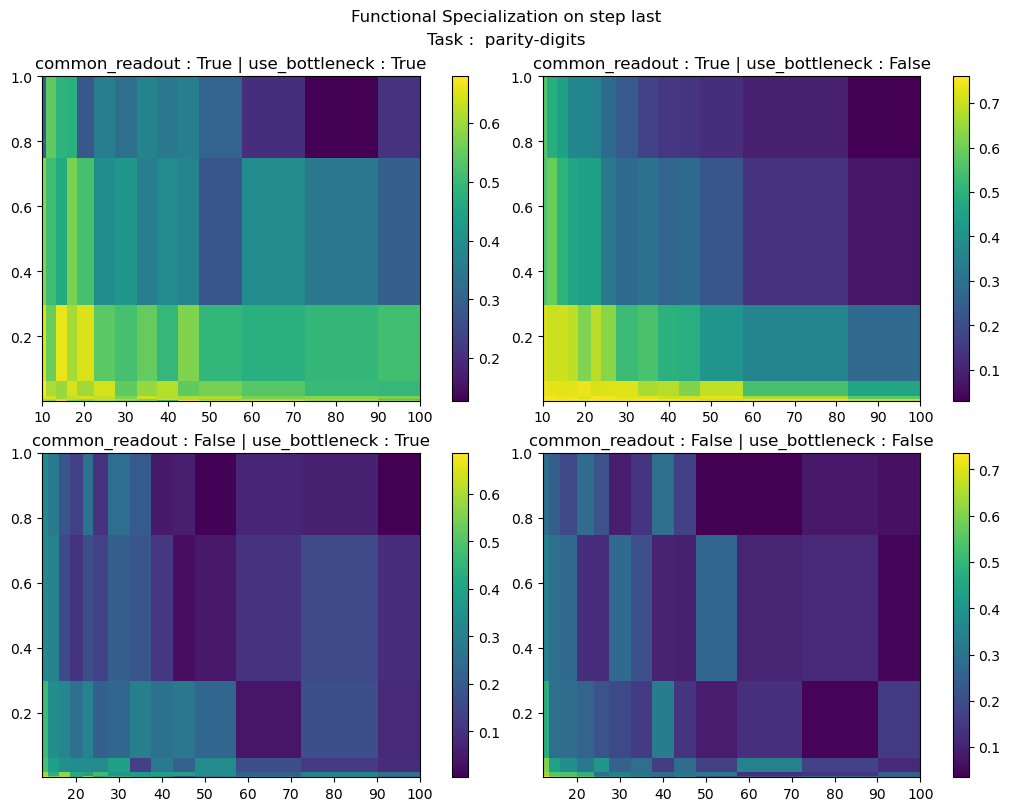

In [9]:
type = 'scipy'

n_tasks = len(tasks)
n_steps = len(steps)

color = 'bottleneck_global_diff'
#color = 'best_acc'

for step in ['last'] :

    s = steps.index(step) 
    
    try : 
        (n1, v_p1), (n2, v_p2) = (tuple(*v.items()) for v in varying_params)
    except ValueError : 
        n_1, v_p1 = list(tuple(*v.items()) for v in varying_params)[0]
        n_2 = 1
        v_p2 = [0]


    fig = plt.figure(
        constrained_layout=True, figsize=(5 * len(v_p1), 2 * n_steps * len(v_p2))
    )
    fig.suptitle(f"Functional Specialization on step {step}")

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=n_tasks, ncols=1)
    if len(f_data) == 1:
        subfigs = [subfigs]

    Zs = []

    for t, (subfig, task) in enumerate(zip(subfigs, tasks)):

        #subfig.suptitle(f"Task :  {task}")
        subfig.suptitle(f"Task :  {task}")

        # create subplots per subfig

        axs = subfig.subplots(nrows=len(v_p1), ncols=len(v_p2))
        try : 
            axs[0]
        except TypeError : 
            axs = [axs]
        # t_values = task_values[task].copy()
        # norm_values = normalized_values[task]

        for i, v1 in enumerate(v_p1):
            for j, v2 in enumerate(v_p2):

                try:
                    ax = axs[i, j]
                except (IndexError, TypeError) as e:
                    ax = axs[i + j]

                #minmax = (
                #    f_data[t][s]["bottleneck_global_diff"].min(),
                #    f_data[t][s]["bottleneck_global_diff"].max(),
                #)

                data = filter_data(filter_data(f_data[t][s], n1, v1), n2, v2)
                argmins = (
                    data[color].values.argsort()[:10],
                    data[color].values.argsort()[-10:],
                )
                minmax = [data[color].values[idxs].mean() for idxs in argmins]
                #print(minmax)
                #print(data.shape)
                values = get_values(data, color)

                if 0 not in data.shape : 
                    if type == 'heatmap' : 
                            
                        (X, Y), (X_mesh, Y_mesh), Z, sigmas, *_ = compute_and_plot_heatmap(
                            values,
                            (fig, ax),
                            log_scale=True,
                            plot_f=False,
                            random=False,
                            minmax=minmax, 
                            smoothness=10
                        )
                    elif type == 'scipy' : 
                        X_mesh, Y_mesh, Z, (fig, ax), cbar = compute_and_plot_colormesh(values, (fig, ax))

                    Zs.append(Z)

                ax.set_title(f"{n1} : {v1} | {n2} : {v2}")

[0.0025 0.005  0.01   0.025  0.1    0.5    1.    ]
[0.0025 0.005  0.01   0.025  0.1    0.5    1.    ]
[0.0025 0.005  0.01   0.025  0.1    0.5    1.    ]


Text(0.5, 0, 'Number of Interconnections')

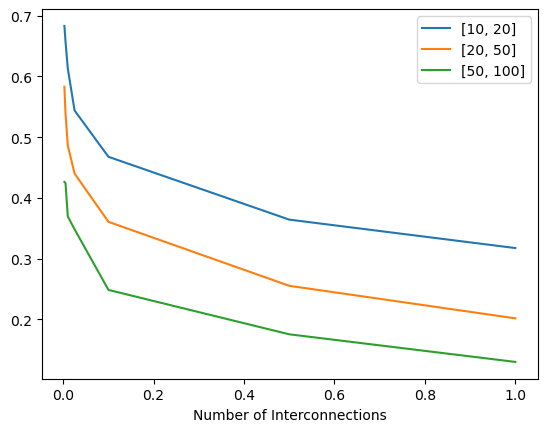

In [52]:
data = f_data[0][1]
data['p_comms'] = data['sparsity'] * data['n_hidden'] ** 2
n_hids = [10, 20, 50, 100]
for n1, n2 in zip(n_hids[:-1], n_hids[1:]) : 
    print(data['sparsity'][filter].unique())
    filter = (data['n_hidden'] > n1) * (data['n_hidden'] < n2) 
    plt.plot(data['sparsity'][filter].unique(), data[filter].groupby('sparsity')['bottleneck_det_col_norm'].mean(), label=f'[{n1}, {n2}]')
plt.legend()
plt.xlabel('Number of Interconnections')

In [66]:
data[['n_hidden', 'sparsity']][data['n_hidden'] == 15]

,n_hidden,sparsity
1,15,0.0025
3,15,0.0025
5,15,0.0025
7,15,0.0025
9,15,0.0050
...,...,...
61,15,1.0000
63,15,1.0000
65,15,1.0000
67,15,1.0000


In [55]:
1 / 15**2

0.0044444444444444444

In [46]:
data['n_comms'] = data['sparsity'] * data['n_hidden'] ** 2

In [31]:
data['sparsity'][filter]

1     0.0025
3     0.0025
5     0.0025
7     0.0025
9     0.0050
       ...  
47    0.5000
49    1.0000
51    1.0000
53    1.0000
55    1.0000
Name: sparsity, Length: 196, dtype: float64

# Parameter Importance

In [41]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree

ModuleNotFoundError: No module named 'sklearn'

In [157]:
rf = RF()

all_features = ["n_hidden", "sparsity", 'common_input', 'common_readout', 'task']

fixed_features = {
    'task' : 'parity-both', 
    #'common_input' : True, 
    'common_readout' : True
}

#fixed_features = {}

data = s_datas[1]
remaining_features = [f for f in all_features if f not in fixed_features]
for f, f_value in fixed_features.items() : 
    data = filter_data(data, f, f_value)

X = data[remaining_features]
y = data['bottleneck_global_diff']

if 'task' in remaining_features : 
    X['task_bool'] = X['task'] == 'all'
    X = X[[f for f in remaining_features if f != 'task'] + ['task_bool']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf.fit(X_train, y_train)

print(np.abs((rf.predict(X_test) - y_test)).mean())

feature_importances = lambda rf : {f : f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)}


0.01407309940493382


In [158]:
feature_importances(rf)

{'n_hidden': 0.5085227390043084,
 'sparsity': 0.2440655353976681,
 'common_input': 0.24741172559802355}

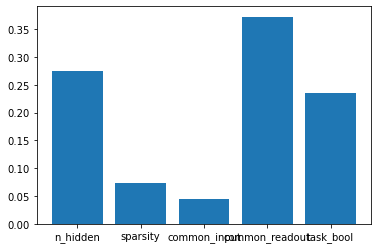

In [150]:
plt.bar(range(len(feature_importances)), feature_importances.values())
plt.xticks(range(len(feature_importances)), list(feature_importances.keys()));

In [148]:
{f : f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)}

{'n_hidden': 0.2742151654845902,
 'sparsity': 0.07345944872166144,
 'common_input': 0.04492315086028073,
 'common_readout': 0.37210631841348746,
 'task_bool': 0.23529591651998027}

In [ ]:
 : d)

In [128]:
data

,Step,best_acc,common_input,common_readout,n_hidden,sparsity,task,bottleneck_det,bottleneck_det_col_norm,bottleneck_norm_1,bottleneck_norm_2,bottleneck_norm_fro,bottleneck_norm_nuc,bottleneck_global_diff,name
1,last,0.970703,True,True,65,0.930604,all,0.083644,0.024107,1.864183,1.862871,1.863412,1.907772,0.024110,glamorous-sweep-2635
3,last,0.973307,True,True,65,0.930604,all,0.028822,0.008200,1.876502,1.874851,1.874914,1.890224,0.008200,glamorous-sweep-2635
5,last,0.961238,True,True,65,0.930604,all,0.029110,0.008328,1.884816,1.869703,1.869768,1.885272,0.008328,glamorous-sweep-2635
7,last,0.974710,True,True,65,0.930604,all,0.001172,0.000336,1.929086,1.870514,1.870514,1.871140,0.000335,glamorous-sweep-2635
9,last,0.964694,True,True,65,0.930604,all,0.089419,0.026214,1.886719,1.847927,1.848561,1.896316,0.026206,glamorous-sweep-2635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,last,0.958534,True,True,90,0.649726,parity-both,0.021351,0.006261,1.854167,1.846801,1.846837,1.858362,0.006261,super-sweep-3442
13,last,0.965945,True,True,90,0.649726,parity-both,0.002795,0.000766,1.928586,1.909898,1.909899,1.911362,0.000766,super-sweep-3442
15,last,0.964894,True,True,90,0.649726,parity-both,0.010324,0.002893,1.889924,1.889123,1.889131,1.894588,0.002893,super-sweep-3442
17,last,0.961989,True,True,90,0.649726,parity-both,0.025257,0.007083,1.907652,1.888570,1.888617,1.901943,0.007083,super-sweep-3442


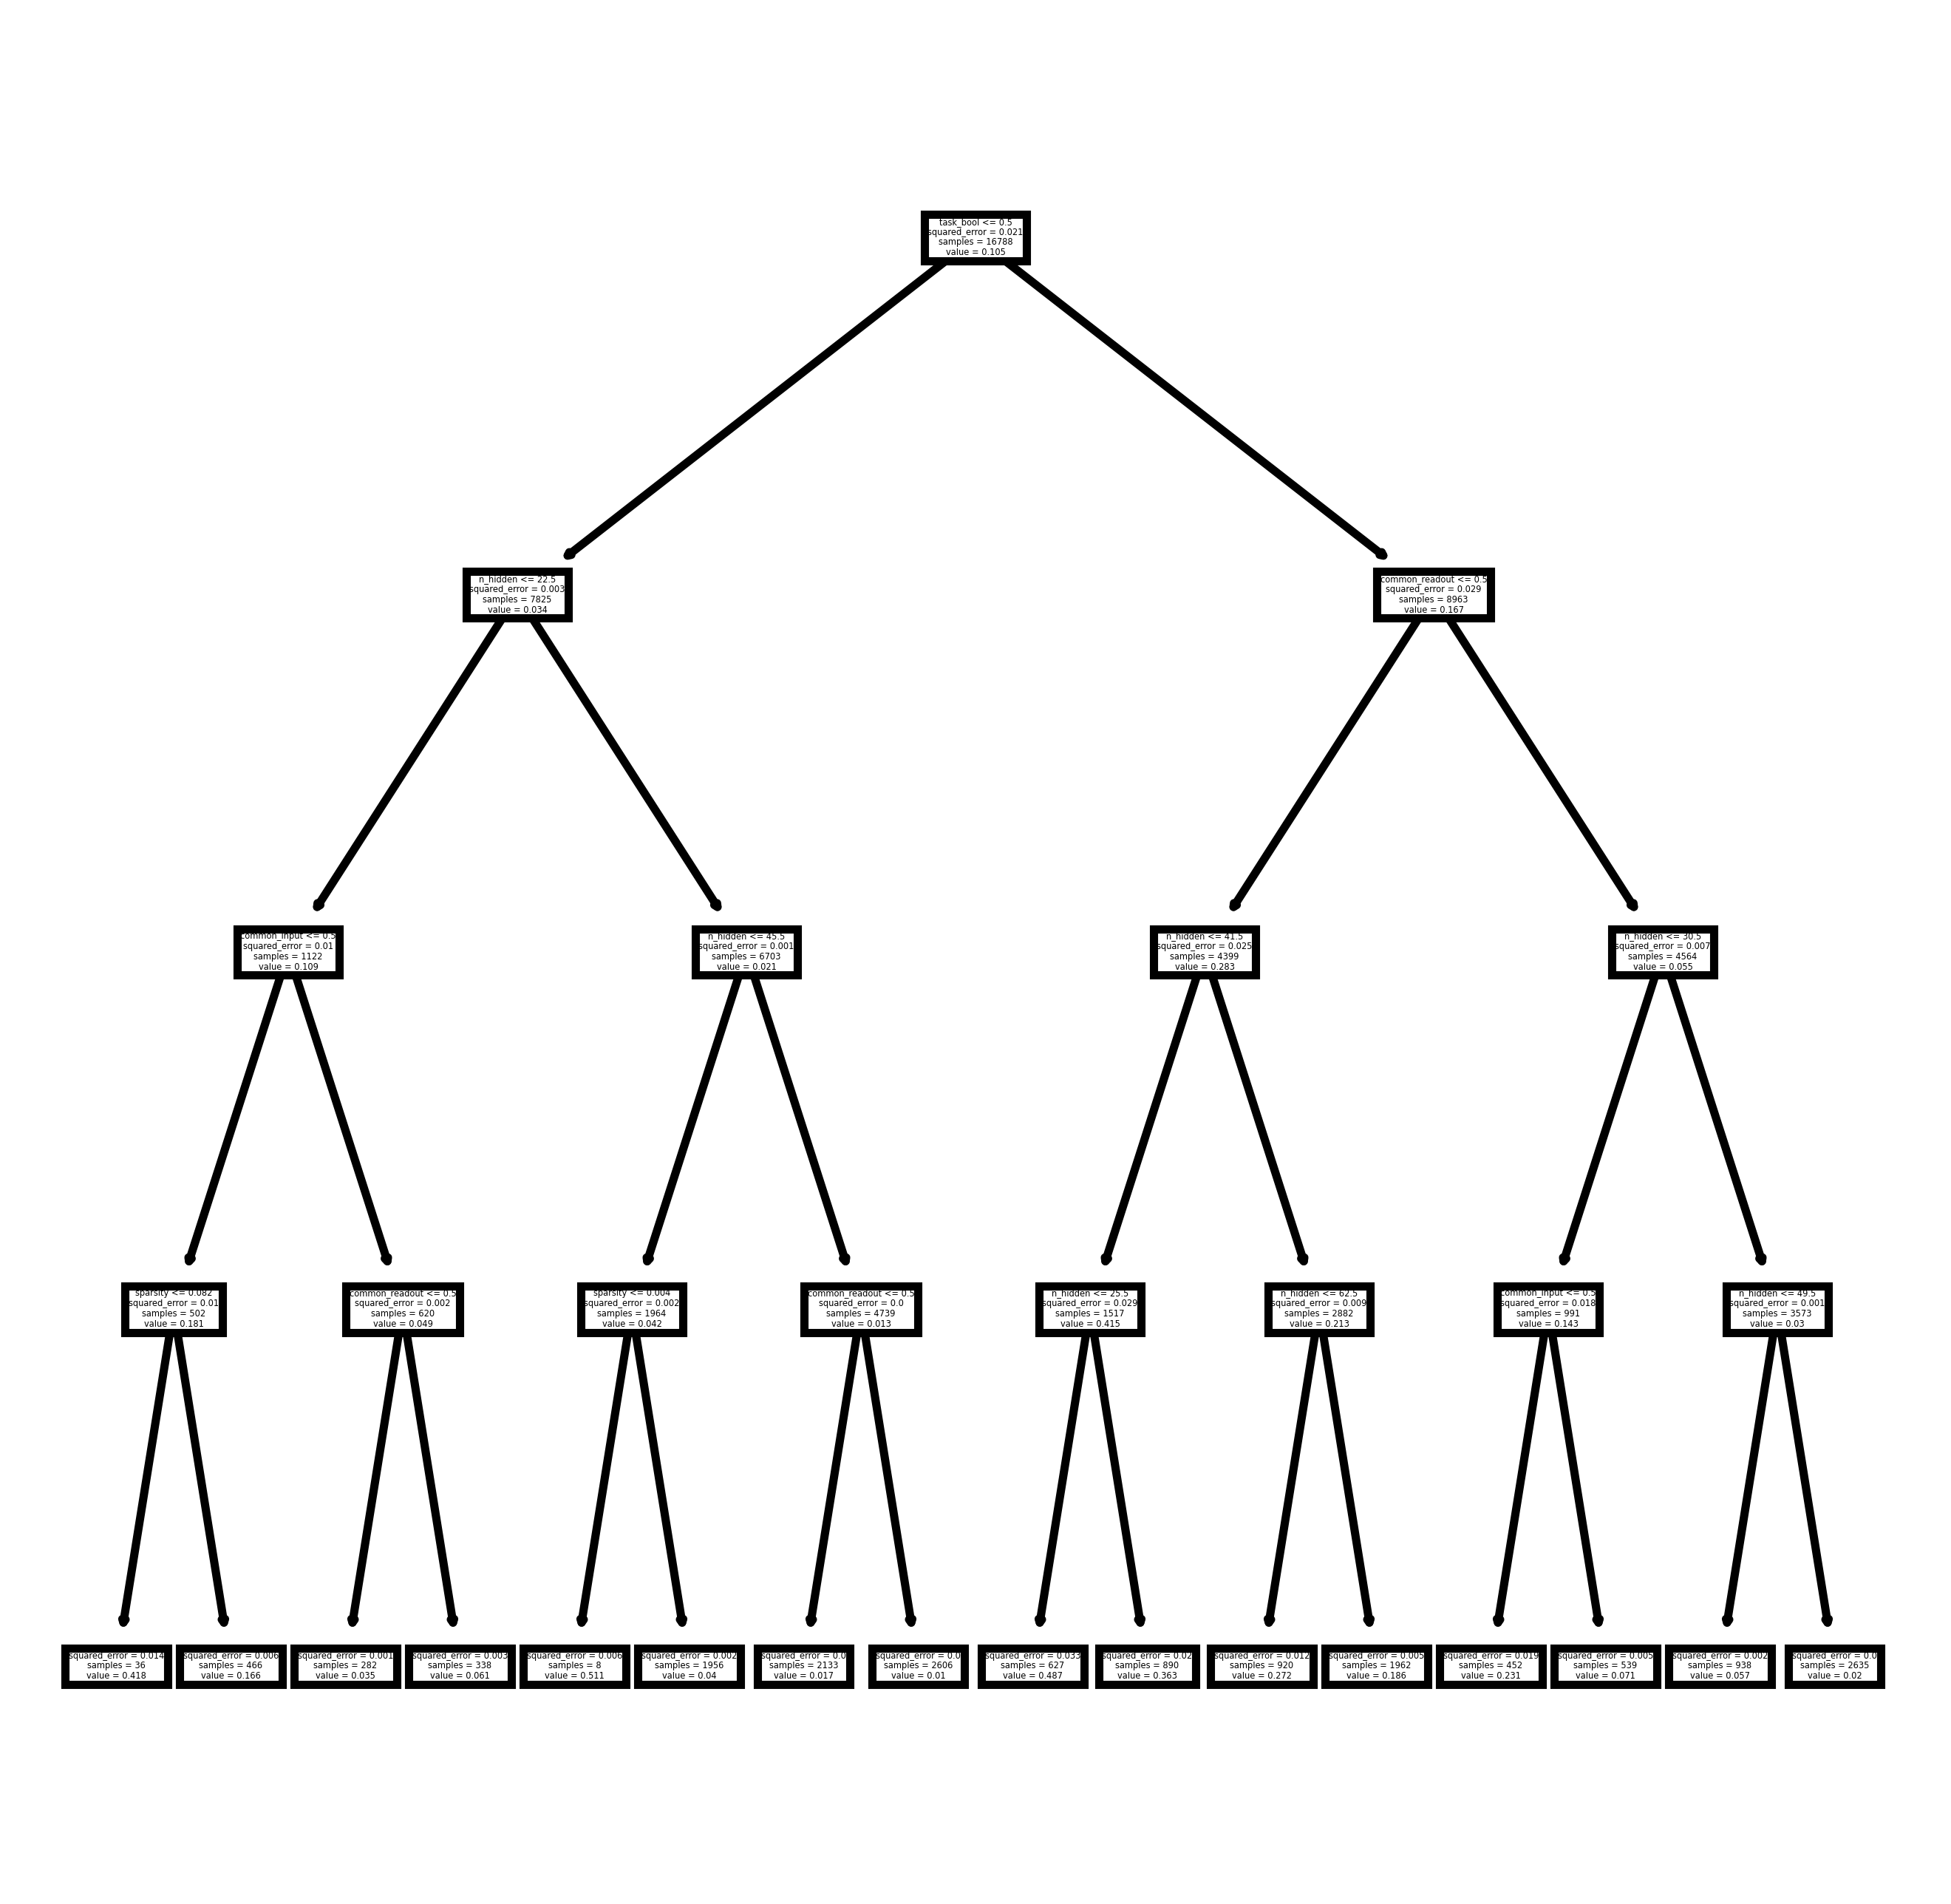

In [113]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plot_tree(rf.estimators_[0], feature_names=rf.feature_names_in_);
fig.savefig('rf_individualtree.png')

# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError


In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))


(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res